In [1]:
# %pip install seaborn

In [2]:
import os
import regex as re
import glob
import unicodedata
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def read_corpus_files(directory_path):
    """
    Read all .txt files from the specified directory and concatenate them.
    
    Args:
        directory_path: Path to the directory containing the .txt files
        
    Returns:
        A string containing all the text data
    """
    all_text = ""
    file_paths = glob.glob(os.path.join(directory_path, "*.txt"))
    
    if not file_paths:
        raise ValueError(f"No .txt files found in {directory_path}")
    
    print(f"Found {len(file_paths)} text files.")
    
    for file_path in tqdm(file_paths, desc="Reading files"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                all_text += text + "\n"
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            
    return all_text

In [4]:
def clean_text(text):
    """
    Remove noise like email addresses, URLs, file markup, etc.
    
    Args:
        text: Input text string
        
    Returns:
        Cleaned text string
    """
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove file markup like [[File:…]]
    text = re.sub(r'\[\[File:[^\]]*\]\]', '', text)
    
    # Remove other markups
    text = re.sub(r'\[\[[^\]]*\]\]', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove script-mismatches (e.g., "100px")
    text = re.sub(r'\d+px', '', text)
    
    # Remove numbers in brackets
    text = re.sub(r'\(\d+\)', '', text)
    
    # Keep only Arabic, Latin letters, numbers, and whitespace
    # This preserves Arabic and Latin text while removing other unwanted characters
    text = re.sub(r'[^\p{Arabic}\p{Latin}\d\s]', ' ', text, flags=re.UNICODE)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [5]:
def normalize_arabic(text):
    """
    Normalize Arabic text by removing diacritics and unifying letter variants.
    
    Args:
        text: Arabic text
        
    Returns:
        Normalized Arabic text
    """
    # Remove diacritics (tashkeel)
    text = re.sub(r'[\u064B-\u065F\u0670]', '', text)
    # Remove tatweel (ـ) character used for justification
    text = text.replace('\u0640', '')
    # Normalize alef variants to plain alef (ا)
    # Normalize alef variants to plain alef (ا)
    text = text.replace('أ', 'ا')
    text = text.replace('إ', 'ا')
    text = text.replace('آ', 'ا')
    text = text.replace('ٱ', 'ا') # Alef Wasla
    
    # Normalize other common variants
    text = text.replace('ة', 'ه')  # ta marbuta -> ha
    text = text.replace('ى', 'ي')  # alef maksura -> ya
    text = text.replace('گ', 'ك')  # variant kaf -> kaf
    
    
    text = text.replace('ڤ', 'ف')  # variant fa -> fa (V)
    text = text.replace('پ', 'ب')  # variant ba -> ba (P)
    
    return text

In [6]:
def romanize_arabic(text):
    """
    Convert Arabic script to Latin/ASCII representation.
    
    Args:
        text: Arabic text
        
    Returns:
        Romanized text
    """
    # Define mapping from Arabic to Latin
    ar_to_lat = {
        # Consonants
        'ا': 'a', 'ب': 'b', 'ت': 't', 'ث': 'th',
        'ج': 'j', 'ح': '7', 'خ': 'kh', 'د': 'd', # ح -> 7
        'ذ': 'dh', 'ر': 'r', 'ز': 'z', 'س': 's',
        'ش': 'sh', 'ص': 's', 'ض': 'd', 'ط': 't', # Simplified ص->s, ض->d, ط->t
        'ظ': 'dh', 'ع': '3', 'غ': 'gh', 'ف': 'f', # ع -> 3
        'ق': '9', 'ك': 'k', 'ل': 'l', 'م': 'm', # ق -> 9
        'ن': 'n', 'ه': 'h', 'و': 'w', 'ي': 'y',
        # Hamza forms -> 2
        'ء': '2', # Hamza
        'ئ': '2', # Yeh with Hamza Above
        # Vowels (simplified - Alef already 'a', Waw 'w', Ya 'y')
        # Diacritics were removed in normalize_arabic
        # Punctuation/Digits will pass through the 'else' clause
    }
    
    # Replace each Arabic character with its Latin equivalent
    # romanized_text = ''
    # for char in text:
    #     if char in ar_to_lat:
    #         romanized_text += ar_to_lat[char]
    #     else:
    #         romanized_text += char
    romanized_text = ''
    for char in text:
        romanized_text += ar_to_lat.get(char, char) # Use get() for safer lookup
            
    return romanized_text

In [7]:
def normalize_arabizi(text):
    """
    Ensure consistent representation of Arabizi (Arabic written with Latin chars).
    This preserves numerical digits used as letters in Arabizi.
    
    Args:
        text: Input text
        
    Returns:
        Normalized Arabizi text
    """
    # Ensure lowercase for consistency
    text = text.lower()
    # Map specific letter sequences in Arabizi
    # These are common digraphs that should be preserved
   
    
    # We already handle the digit-as-letter mapping in the romanization step
    # This function can be expanded for other Arabizi normalization as needed
        # Common digraph normalizations (apply carefully, might depend on dialect/style)
    text = re.sub(r'ch', 'sh', text)  # e.g., chnou -> shnou
    text = re.sub(r'ou', 'u', text) # e.g., chouf -> chuf (optional, can change meaning)

    # Normalize repeated letters (common in chat) - optional
    text = re.sub(r'(.)\1{2,}', r'\1\1', text) # e.g., waaaaaw -> waaw

    # Specific number-to-letter mappings if needed (though romanize_arabic handles the main ones)
    text = text.replace('5', 'kh') # If 'kh' is preferred over '5' which wasn't mapped

    return text
    
   

In [8]:
def tokenize_text(text):
    """
    Tokenize the text on whitespace and punctuation.
    
    Args:
        text: Input text
        
    Returns:
        List of tokens
    """
    # Simple whitespace tokenization for now
    # Consider more advanced tokenizers
    # (like nltk.word_tokenize or spaCy) for handling punctuation better if needed.
    tokens = text.split()
    # Optional: Filter out very short tokens if they are likely noise
    # tokens = [token for token in tokens if len(token) > 1]
    return tokens

In [9]:
def preprocess_darija_corpus(directory_path, sample_size=None):
    """
    Complete preprocessing pipeline for Darija corpus.
    
    Args:
        directory_path: Path to directory containing .txt files
        sample_size: If specified, only process this many characters (for testing)
        
    Returns:
        Tuple of (raw_text, cleaned_text, tokens, corpus_stats)
    """
    print("Step 1: Reading corpus files...")
    raw_text_full = read_corpus_files(directory_path) # Read full first for stats

    raw_char_count = len(raw_text_full)
    # Estimate word count on raw text before sampling
    word_count_approx = len(re.findall(r'\b\w+\b', raw_text_full))
    print(f"\nRaw corpus statistics (full):")
    print(f"- Total characters: {raw_char_count}")
    print(f"- Total words (approx): {word_count_approx}")

    # Apply sampling *after* getting full stats if needed
    if sample_size:
        print(f"\nTaking a sample of {sample_size} characters for processing...")
        raw_text_processed = raw_text_full[:sample_size]
    else:
        raw_text_processed = raw_text_full
   
    
    print("\nStep 2: Cleaning text...")
    cleaned_text = clean_text(raw_text_processed)
    
    print("\nStep 3: Normalizing Arabic text...")
    normalized_text = normalize_arabic(cleaned_text)
    
    print("\nStep 4: Romanizing text...")
    romanized_text = romanize_arabic(normalized_text)
    
    print("\nStep 5: Normalizing Arabizi...")
    final_text = normalize_arabizi(romanized_text)
    
    print("\nStep 6: Tokenizing text...")
    tokens = tokenize_text(final_text)
    
    # Calculate some corpus statistics
    corpus_stats = {
        "raw_chars": len(raw_text_processed),
        "cleaned_chars": len(final_text),
        "total_tokens": len(tokens),
        "unique_tokens": len(set(tokens)),
        "avg_token_length": sum(len(t) for t in tokens) / len(tokens) if tokens else 0
    }
    
    print("\nFinal corpus statistics:")
    print(f"- Total characters: {corpus_stats['cleaned_chars']}")
    print(f"- Total tokens: {corpus_stats['total_tokens']}")
    print(f"- Unique tokens: {corpus_stats['unique_tokens']}")
    print(f"- Average token length: {corpus_stats['avg_token_length']:.2f}")
    
    return raw_text_processed, final_text, tokens, corpus_stats

In [10]:
def analyze_corpus(tokens, top_n=30):
    """
    Analyze the corpus and create visualizations.
    
    Args:
        tokens: List of tokens from the corpus
        top_n: Number of top tokens to display
        
    Returns:
        DataFrame with token frequency information
    """
    # Calculate token frequencies
    token_freq = {}
    for token in tokens:
        if token in token_freq:
            token_freq[token] += 1
        else:
            token_freq[token] = 1
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame.from_dict(token_freq, orient='index', columns=['frequency'])
    df = df.sort_values('frequency', ascending=False).reset_index()
    df.columns = ['token', 'frequency']
    
    # Add token length
    df['length'] = df['token'].apply(len)
    
    # Calculate relative frequency
    total_tokens = len(tokens)
    df['rel_frequency'] = df['frequency'] / total_tokens
    
    # Plot top token frequencies
    plt.figure(figsize=(12, 6))
    sns.barplot(x='token', y='frequency', data=df.head(top_n))
    plt.title(f'Top {top_n} Token Frequencies')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot token length distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(df['length'], bins=20)
    plt.title('Token Length Distribution')
    plt.xlabel('Token Length')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    return df

In [11]:
corpus_dir = 'data'

Step 1: Reading corpus files...
Found 39 text files.


Reading files:   0%|          | 0/39 [00:00<?, ?it/s]


Raw corpus statistics (full):
- Total characters: 621637987
- Total words (approx): 101371633

Step 2: Cleaning text...

Step 3: Normalizing Arabic text...

Step 4: Romanizing text...

Step 5: Normalizing Arabizi...

Step 6: Tokenizing text...

Final corpus statistics:
- Total characters: 598092600
- Total tokens: 101229938
- Unique tokens: 4975067
- Average token length: 4.91
Sample of processed text:
allh ys3dkm f 7yatkwm da2ma w abda ly 9al amyn f nfsw ykhly jym als3ayh 3y9tw bzaf hda b7al skwatsh w tnys alslam 3lykm m3km akhtkm am fdl mn swrya zwjt shhyd wldy 4awlad thlath bnat wwld wlys ly m3yn


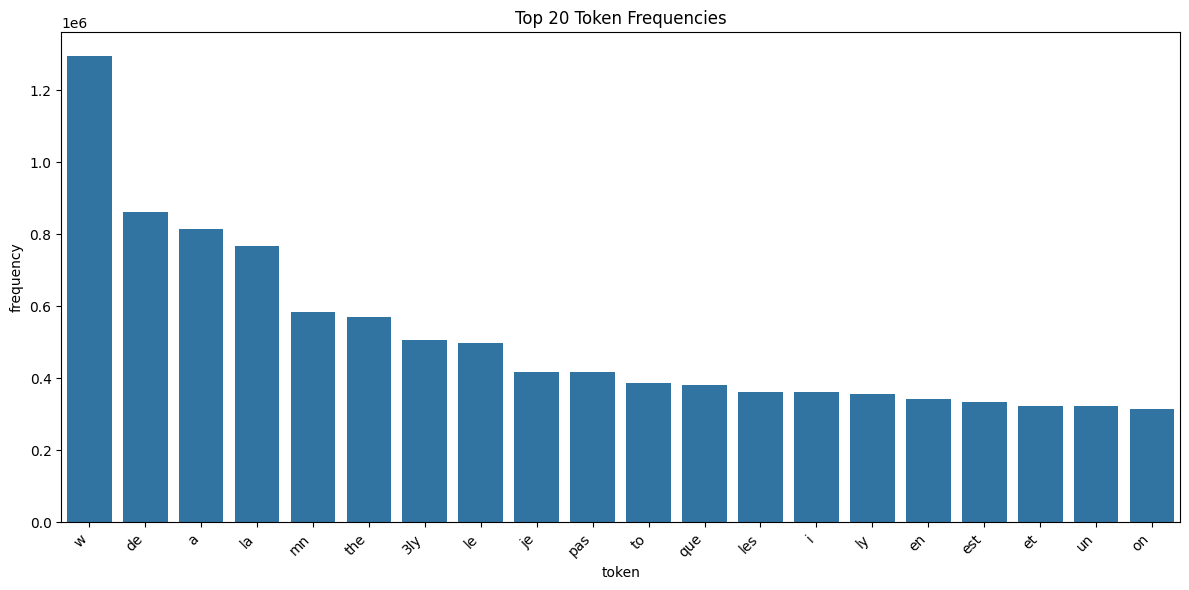

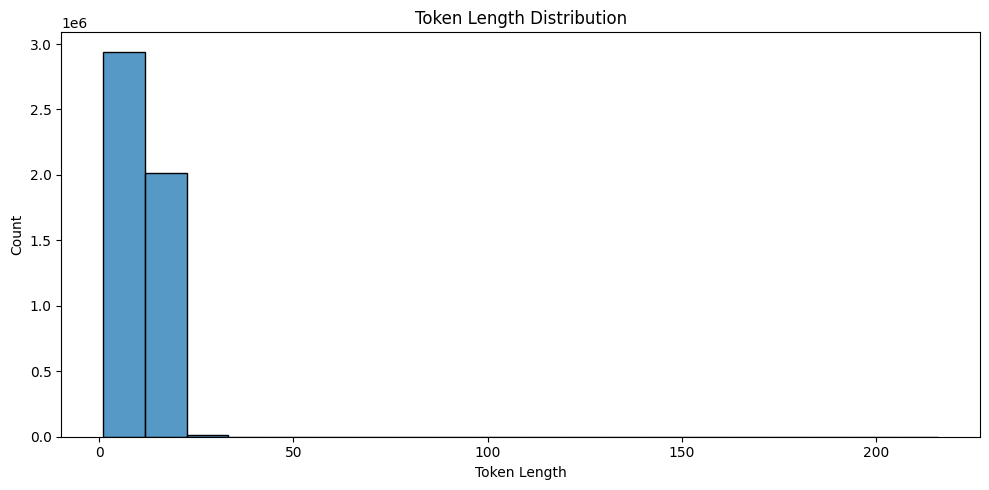

Top 20 tokens:
Saved preprocessed corpus to preprocessed_darija_corpus.txt
Saved 101229938 tokens to darija_tokens.txt


In [12]:
# For testing purposes, you might want to use a small sample first

# %%
# Process a sample of the corpus (set sample_size=None to process the entire corpus)
raw_text, processed_text, tokens, stats = preprocess_darija_corpus(
    corpus_dir, 
    sample_size=None  # Use a smaller sample for quick testing
)

# %% [markdown]
# ## Analyze the Preprocessed Corpus

# %%
# Display a sample of the processed text
print("Sample of processed text:")
print(processed_text[:200])

# %%
# Analyze token frequencies and distributions
token_df = analyze_corpus(tokens, top_n=20)

# %%
# Display top tokens and their frequencies
print("Top 20 tokens:")
token_df.head(20)

# %% [markdown]
# ## Save the Preprocessed Corpus

# %%
# Save the processed text to a file for future use
output_file = 'preprocessed_darija_corpus.txt'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write(processed_text)
print(f"Saved preprocessed corpus to {output_file}")

# %%
# Save the token list (one token per line) for word2vec training
tokens_file = 'darija_tokens.txt'
with open(tokens_file, 'w', encoding='utf-8') as f:
    for token in tokens:
        f.write(token + '\n')
print(f"Saved {len(tokens)} tokens to {tokens_file}")